In [1]:
# Make sure you have the following packages installed:
!pip install spacy torchtext portalocker --quiet

In [2]:
!pip install torchdata

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import spacy
import os
import matplotlib.pyplot as plt

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

In [5]:
torch.manual_seed(42)  # For reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Multi-Head Attention

$$
    \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O \\
    \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) \\  
    \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

In [6]:
class MultiHeadAttention(nn.Module):
    """The multi-head attention module"""
    def __init__(self, d_model, num_heads):
        super().__init__()

        # Ensure the dimension of the model is divisible by the number of heads.
        # This is necessary to equally divide the embedding dimension across heads.
        assert d_model % num_heads == 0, 'd_model must be divisible by num_heads'

        self.d_model = d_model           # Total dimension of the model
        self.num_heads = num_heads       # Number of attention heads
        self.d_k = d_model // num_heads  # Dimnsion of each head. We assume d_v = d_k

        # Linear transformations for queries, keys, and values
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # Final linear layer to project the concatenated heads' outputs back to d_model dimensions
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        ### WRITE YOUR CODE HERE

        d_k = Q.shape[-1]
        
        # 1. Calculate attention scores with scaling.
        attention_scores = torch.matmul(Q , K.transpose(-2, -1)) / math.sqrt(d_k)
        
        # 2. Apply mask (if provided) by setting masked positions to a large negative value.
        if mask is not None:
          attention_scores = attention_scores.masked_fill_(mask == 0, -1e9)
        
        # 3. Apply softmax to attention scores to get probabilities.
        attention_weights = torch.softmax(attention_scores, dim = -1)
        
        # 4. Return the weighted sum of values based on attention probabilities.
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

    def split_heads(self, x):
        # Reshape the input tensor to [batch_size, num_heads, seq_length, d_k]
        # to prepare for multi-head attention processing
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Inverse operation of split_heads: combine the head outputs back into the original tensor shape
        # [batch_size, seq_length, d_model]
        batch_size, num_heads, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        ### WRITE YOUR CODE HERE
        
        # 1. Linearly project the queries, keys, and values, and then split them into heads.
        # [batch_size, seq_length, d_model] -> [batch_size, seq_length, d_model] -> [batch_size, seq_length, num_heads, d_k] -> [batch_size, num_heads, seq_length, d_k]
        query = self.split_heads(self.W_q(Q))
        key = self.split_heads(self.W_k(K))
        value = self.split_heads(self.W_v(V))
        
        # 2. Apply scaled dot-product attention for each head.
        # [batch_size, num_heads, seq_length, d_k] --> [batch_size, num_heads, seq_length, seq_length] --> [batch_size, num_heads, seq_length, d_k]
        x, attention = self.scaled_dot_product_attention(query, key, value, mask)

        # 3. Concatenate the heads' outputs and apply the final linear projection.
        # [batch_size, num_heads, seq_length, d_k] --> [batch_size, seq_length, d_model]
        x = self.combine_heads(x)
        output = self.W_o(x)

        return output

### Feed-Forward NN

$$
    \text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
$$

In [7]:
class PositionwiseFeedForward(nn.Module):
    """The Positionwise Feedforward Network (FFN) module"""
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        ### WRITE YOUR CODE HERE
        # [batch_size, seq_length, d_model] --> [batch_size, seq_length, d_ff] --> [batch_size, seq_length, d_model]
       return self.linear2(self.dropout(self.relu(self.linear1(x))))

### Positional Encoding

$$
    \text{PE}(pos, 2i) = \sin(pos/10000^{2i/d_{\text{model}}}) \\
    \text{PE}(pos, 2i + 1) = \cos(pos/10000^{2i/d_{\text{model}}})
$$

In [8]:
class PositionalEncoding(nn.Module):
    """
    Implements the positional encoding module using sinusoidal functions of different frequencies
    for each dimension of the encoding.
    """
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        # Create a positional encoding (PE) matrix with dimensions [max_seq_length, d_model].
        # This matrix will contain the positional encodings for all possible positions up to max_seq_length.
        pe = torch.zeros(max_seq_length, d_model)

        # Generate a tensor of positions (0 to max_seq_length - 1) and reshape it to [max_seq_length, 1].
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

        # Compute the division term used in the formulas for sin and cos functions.
        # This term is based on the dimension of the model and the position, ensuring that the wavelengths
        # form a geometric progression from 2π to 10000 * 2π. It uses only even indices for the dimensions.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply the sin function to even indices in the PE matrix. These values are determined by
        # multiplying the position by the division term, creating a pattern where each position has
        # a unique sinusoidal encoding.
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply the cos function to odd indices in the PE matrix, complementing the sin-encoded positions.
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register 'pe' as a buffer within the module. Unlike parameters, buffers are not updated during training.
        # This is crucial because positional encodings are fixed and not subject to training updates.
        # The unsqueeze(0) adds a batch dimension for easier broadcasting with input tensors.
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Add positional encoding to the input tensor x.
        # x is expected to have dimensions [batch_size, seq_length, d_model].
        # The positional encoding 'pe' is sliced to match the seq_length of 'x', and then added to 'x'.
        # This operation leverages broadcasting to apply the same positional encoding across the batch.
        x = x + self.pe[:, :x.size(1)]
        return x

### Encoder Layer

In [9]:
class EncoderLayer(nn.Module):
    """An encoder layer consists of a multi-head self-attention sublayer and a feed forward sublayer,
       with a dropout, residual connection, and layer normalization after each sub-layer.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        ### WRITE YOUR CODE HERE
        self_attention_output = self.self_attn(x, x, x, mask)
        x = self.layer_norm1(x + self.dropout(self_attention_output))

        feed_forward_output = self.feed_forward(x)
        x = self.layer_norm2(x + self.dropout(feed_forward_output))

        return x


### Decoder Layer

In [10]:
class DecoderLayer(nn.Module):
    """A decoder layer consists of a multi-head self-attention, cross-attention and a feed-forward sublayers,
       with a dropout, residual connection, and layer normalization after each sub-layer.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.layer_norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        ### WRITE YOUR CODE HERE
        self_attention_output = self.self_attn(x, x, x, tgt_mask)
        x = self.layer_norm1(x + self.dropout(self_attention_output))

        cross_attention_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.layer_norm2(x + self.dropout(cross_attention_output))

        feed_forward_output = self.feed_forward(x)
        x = self.layer_norm3(x + self.dropout(feed_forward_output))

        return x


### The Full Model

In [11]:
class Transformer(nn.Module):
    """
    Implements the Transformer model for sequence-to-sequence tasks such as machine translation.
    The Transformer model, as described in "Attention is All You Need" by Vaswani et al., consists of an encoder and
    decoder architecture that uses self-attention mechanisms to process input sequences and generate output sequences.

    Parameters:
    - src_vocab_size (int): Size of the source vocabulary.
    - tgt_vocab_size (int): Size of the target vocabulary.
    - d_model (int): Dimension of the model embeddings and hidden states.
    - N (int): Number of layers in both the encoder and decoder stacks.
    - n_heads (int): Number of attention heads in each multi-head attention mechanism.
    - d_ff (int): Dimension of the feed-forward network within each layer.
    - max_seq_length (int): Maximum length of input sequences, used for positional encoding.
    - dropout (float): Dropout rate applied to embeddings and sub-layers.
    - pad_idx (int): Index of the padding token in the source and target vocabularies.

    Attributes:
    - src_embedding (torch.nn.Embedding): Embedding layer for source sequences.
    - tgt_embedding (torch.nn.Embedding): Embedding layer for target sequences.
    - positional_encoding (PositionalEncoding): Adds positional information to embeddings.
    - encoder (torch.nn.ModuleList): Stack of N encoder layers.
    - decoder (torch.nn.ModuleList): Stack of N decoder layers.
    - out (torch.nn.Linear): Linear layer that projects decoder output to target vocabulary size.
    - dropout (torch.nn.Dropout): Dropout layer applied after embedding and positional encoding.

    Methods:
    - init_weights: Initializes model parameters using Glorot uniform initialization.
    - create_source_mask: Creates a mask for padding tokens in the source sequence to ignore them in attention computations.
    - create_target_mask: Creates combined padding and future token masks for the target sequence to prevent attending to future tokens and padding tokens.
    - encode: Processes the source sequence through the encoder stack and generates memory states.
    - decode: Processes the target sequence through the decoder stack using memory states from the encoder and applicable masks.
    - forward: Defines the forward pass of the model using the encode and decode methods.
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, N, n_heads, d_ff, max_seq_length, dropout, pad_idx):
        super().__init__()

        # Embedding layers for source and target
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Encoder and Decoder stacks
        self.encoder = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(N)])
        self.decoder = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(N)])

        # Output linear layer
        self.out = nn.Linear(d_model, tgt_vocab_size)

        self.dropout = nn.Dropout(dropout)

        # Initialization
        self.init_weights()
        self.pad_idx = pad_idx

    def init_weights(self):
        """Initialize parameters with Glorot / fan_avg"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def create_source_mask(self, src):
        """Create a mask for padding tokens in the source"""
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, src_len]
        # unsqueeze(1) adds a dimension for the heads of the multi-head attention
        # unsqueeze(2) adds a dimension for the attention scores
        # This mask can be broadcasted across the src_len dimension of the attention scores,
        # effectively masking out specific tokens across all heads and all positions in the sequence.
        return src_mask

    def create_target_mask(self, tgt):
        """Create masks for both padding tokens and future tokens"""
        # Target padding mask
        tgt_pad_mask = (tgt != self.pad_idx).unsqueeze(1).unsqueeze(3)  # [batch_size, 1, tgt_len, 1]
        # unsqueeze(1) adds a dimension for the heads of the multi-head attention
        # unsqueeze(3) adds a dimension for the attention scores
        # The final shape allows the mask to be broadcast across the attention scores, ensuring positions only
        # attend to allowed positions as dictated by the no-peak mask (the preceding positions) and the padding mask.

        # Target no-peak mask
        tgt_len = tgt.size(1)
        tgt_nopeak_mask = torch.tril(torch.ones(tgt_len, tgt_len, device=device)).bool()

        # Combine masks
        tgt_mask = tgt_pad_mask & tgt_nopeak_mask  # [batch_size, 1, tgt_len, tgt_len]
        return tgt_mask

    def encode(self, src):
        """Encodes the source sequence using the Transformer encoder stack.
        """
        src_mask = self.create_source_mask(src)
        src = self.dropout(self.positional_encoding(self.src_embedding(src)))

        # Pass through each layer in the encoder
        for layer in self.encoder:
            src = layer(src, src_mask)
        return src, src_mask

    def decode(self, tgt, memory, src_mask):
        """Decodes the target sequence using the Transformer decoder stack, given the memory from the encoder.
        """
        tgt_mask = self.create_target_mask(tgt)
        tgt = self.dropout(self.positional_encoding(self.tgt_embedding(tgt)))

        # Pass through each layer in the decoder
        for layer in self.decoder:
            tgt = layer(tgt, memory, src_mask, tgt_mask)

        # Output layer
        output = self.out(tgt)
        return output

    def forward(self, src, tgt):
        ### WRITE YOUR CODE HERE
        src, src_mask = self.encode(src)
        output = self.decode(tgt, src, src_mask)
        return torch.log_softmax(output, dim = -1)

In [12]:
# Define the hyperparameters of the model
src_vocab_size = 5000  # Size of source vocabulary
tgt_vocab_size = 5000  # Size of target vocabulary
d_model = 512          # Embedding dimension
N = 6                  # Number of encoder and decoder layers
num_heads = 8          # Number of attention heads
d_ff = 2048            # Dimension of feed forward networks
max_seq_length = 100   # Maximum sequence length
dropout = 0.1          # Dropout rate
pad_idx = 0            # Index of the padding token

model = Transformer(src_vocab_size, tgt_vocab_size, d_model, N, num_heads, d_ff, max_seq_length, dropout, pad_idx)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

### Testing on Random Data

In [13]:
# Generate random sample data
torch.manual_seed(42)

src_data = torch.randint(1, src_vocab_size, (64, max_seq_length)).to(device)  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length)).to(device)  # (batch_size, seq_length)

#### Inference

In [14]:
# Generate the next token using the first token in the first target tensor
model.eval()

memory, src_mask = model.encode(src_data[:1, :])
output = model.decode(tgt_data[:1, :1], memory, src_mask)
y = output.view(-1, tgt_vocab_size).argmax(-1)
y

tensor([990], device='cuda:0')

If your code is correct, you should get tensor([990]).

#### Training

In [15]:
# Train the model for 10 epochs
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)
grad_clip = 1
n_epochs = 10

model.train()

for epoch in range(n_epochs):
    optimizer.zero_grad()

    # Forward pass
    output = model(src_data, tgt_data[:, :-1])

    # tgt_data is of shape [batch_size, tgt_len]
    # output is of shape [batch_size, tgt_len, tgt_vocab_size]
    output = output.contiguous().view(-1, tgt_vocab_size)
    tgt = tgt_data[:, 1:].contiguous().view(-1)
    loss = criterion(output, tgt)

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    print(f'Epoch: {epoch + 1}, Loss: {loss.item()}')

Epoch: 1, Loss: 8.605189323425293
Epoch: 2, Loss: 8.501506805419922
Epoch: 3, Loss: 8.371408462524414
Epoch: 4, Loss: 8.29694652557373
Epoch: 5, Loss: 8.238503456115723
Epoch: 6, Loss: 8.19219970703125
Epoch: 7, Loss: 8.164860725402832
Epoch: 8, Loss: 8.142218589782715
Epoch: 9, Loss: 8.130304336547852
Epoch: 10, Loss: 8.121999740600586


You should see the loss decreasing from around 8.6 to 8.1.

### Machine Translation Example

We now consider a real-world example using the Multi30k German-English translation task. This task is much smaller than the WMT task considered in the paper (only 30K sentence pairs compared to 4.5M pairs in the WMT-14 English-German dataset), but it illustrates the whole system. <br>
It is recommended to run this example on Google Colab, or on a machine with a strong GPU.

#### Define Tokenizers

In [16]:
# Load spacy models for tokenization
try:
    spacy_de = spacy.load('de_core_news_sm')
except IOError:
    os.system("python -m spacy download de_core_news_sm")
    spacy_de = spacy.load('de_core_news_sm')

try:
    spacy_en = spacy.load('en_core_web_sm')
except IOError:
    os.system("python -m spacy download en_core_web_sm")
    spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def yield_tokens(data_iter, tokenizer, language):
    for data_sample in data_iter:
        yield tokenizer(data_sample[language])

tokenizer_de = get_tokenizer(tokenize_de)
tokenizer_en = get_tokenizer(tokenize_en)

#### Build Vocabularies

In [17]:
train_data, _, _ = Multi30k(split=('train', 'valid', 'test'))
vocab_src = build_vocab_from_iterator(yield_tokens(train_data, tokenizer_de, 0),
                                      specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab_tgt = build_vocab_from_iterator(yield_tokens(train_data, tokenizer_en, 1),
                                      specials=['<unk>', '<pad>', '<bos>', '<eos>'])

vocab_src.set_default_index(vocab_src['<unk>'])
vocab_tgt.set_default_index(vocab_tgt['<unk>'])

/opt/conda/lib/python3.10/site-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


#### Create the Transformer

In [24]:
# Define the hyperparameters of the model
src_vocab_size = len(vocab_src)  # Size of source vocabulary
tgt_vocab_size = len(vocab_tgt)  # Size of target vocabulary
d_model = 512  # Embedding dimension
N = 6          # Number of encoder and decoder layers
num_heads = 8  # Number of attention heads
d_ff = 2048    # Dimension of feed forward networks
max_seq_length = 5000 # Maximum sequence length
dropout = 0.1  # Dropout rate

# Assume pad_idx is the padding index in the target vocabulary
pad_idx = vocab_tgt['<pad>']

# Initialize the Transformer model
model = Transformer(src_vocab_size, tgt_vocab_size, d_model, N, num_heads, d_ff, max_seq_length, dropout, pad_idx)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Hyperparameters for the training process
batch_size = 128
grad_clip = 1
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Initialize the loss function with CrossEntropyLoss, ignoring the padding index
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

#### Data Processing

In [19]:
def data_process(raw_data_iter):
    data = []
    for raw_src, raw_tgt in raw_data_iter:
        src_tensor = torch.tensor([vocab_src[token] for token in tokenizer_de(raw_src)], dtype=torch.long)
        tgt_tensor = torch.tensor([vocab_tgt[token] for token in tokenizer_en(raw_tgt)], dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    return data

train_data, valid_data, test_data = Multi30k(split=('train', 'valid', 'test'))
train_data = data_process(train_data)
valid_data = data_process(valid_data)
#test_data = data_process(test_data)
# The test set of Multi30k is corrupted
# See https://discuss.pytorch.org/t/unicodedecodeerror-when-running-test-iterator/192818/3

In [20]:
def generate_batch(data_batch):
    """Processes a batch of source-target pairs by adding start-of-sequence (BOS) and end-of-sequence (EOS) tokens
    to each sequence and padding all sequences to the same length.

    Parameters:
    - data_batch (Iterable[Tuple[Tensor, Tensor]]): A batch of source-target pairs, where each element is a tuple
      containing the source sequence tensor and the target sequence tensor.
    """
    src_batch, tgt_batch = [], []
    src_batch, tgt_batch = [], []

    # Iterate over each source-target pair in the provided batch
    for src_item, tgt_item in data_batch:
        # Prepend the start-of-sequence (BOS) token and append the end-of-sequence (EOS) token to the sequences
        src_batch.append(torch.cat([torch.tensor([vocab_src['<bos>']]), src_item,
                                    torch.tensor([vocab_src['<eos>']])], dim=0))
        tgt_batch.append(torch.cat([torch.tensor([vocab_tgt['<bos>']]), tgt_item,
                                    torch.tensor([vocab_tgt['<eos>']])], dim=0))

    # Pad the sequences in the source batch to ensure they all have the same length.
    # 'batch_first=True' indicates that the batch dimension should come first in the resulting tensor.
    src_batch = pad_sequence(src_batch, padding_value=vocab_src['<pad>'], batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=vocab_tgt['<pad>'], batch_first=True)
    return src_batch, tgt_batch

# DataLoader for the training data, using the generate_batch function as the collate_fn.
# This allows custom processing of each batch (adding BOS/EOS tokens and padding) before being fed into the model.
train_iterator = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

# Similarly, DataLoader for the validation data
valid_iterator = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [21]:
def train(model, iterator, optimizer, criterion, grad_clip):
    """
    Trains the model for one epoch over the given dataset.
    This function iterates over the provided data iterator, performing the forward and backward passes for each batch.
    It employs teacher forcing by feeding the shifted target sequence (excluding the last token) as input to the decoder.

    Parameters:
    - model (torch.nn.Module): The model to be trained.
    - iterator (Iterable): An iterable object that returns batches of data.
    - optimizer (torch.optim.Optimizer): The optimizer to use for updating the model parameters.
    - criterion (Callable): The loss function used to compute the difference between the model's predictions and the actual targets.
    - grad_clip (float): The maximum norm of the gradients for gradient clipping.

    Returns:
    - float: The average loss for the epoch, computed as the total loss over all batches divided by the number of batches in the iterator.
    """
    # Set the model to training mode.
    # This enables dropout, layer normalization etc., which behave differently during training.
    model.train()

    epoch_loss = 0

    # Enumerate over the data iterator to get batches
    for i, batch in enumerate(iterator):
        # Unpack the batch to get source (src) and target (tgt) sequences
        src, tgt = batch
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()

        # Forward pass through the model.
        # For seq2seq models, the decoder input (tgt[:, :-1]) excludes the last token, implementing teacher forcing.
        output = model(src, tgt[:, :-1])

        # Reshape the output and target tensors to compute loss.
        # The output tensor is reshaped to a 2D tensor where rows correspond to each token in the batch and columns to vocabulary size.

        # tgt is of shape [batch_size, tgt_len]
        # output is of shape [batch_size, tgt_len, tgt_vocab_size]
        output = output.contiguous().view(-1, tgt_vocab_size)

        # The target tensor is reshaped to a 1D tensor, excluding the first token (BOS) from each sequence.
        tgt = tgt[:, 1:].contiguous().view(-1)

        # Compute loss, perform backpropagation, and update model parameters
        loss = criterion(output, tgt)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        epoch_loss += loss.item()

    # Compute average loss per batch for the current epoch
    return epoch_loss / len(iterator)

In [22]:
def evaluate(model, iterator, criterion):
    """
    Evaluates the model's performance on a given dataset.
    This function is similar to the training loop, but without the backward pass and parameter updates.
    """
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, tgt = batch
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt[:, :-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            tgt = tgt[:, 1:].contiguous().view(-1)
            loss = criterion(output, tgt)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

#### Training the Model

In [25]:
n_epochs = 20

train_losses_1 = []
val_losses_1 = []

for epoch in range(n_epochs):
    train_loss = train(model, train_iterator, optimizer, criterion, grad_clip)
    val_loss = evaluate(model, valid_iterator, criterion)
    
    train_losses_1.append(train_loss)
    val_losses_1.append(val_loss)
    
    print(f'\nEpoch: {epoch + 1}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tVal Loss: {val_loss:.3f}')

perplexity_1 = float(torch.exp(torch.tensor(val_losses_1[-1])).numpy())



Epoch: 1
	Train Loss: 5.702
	Val Loss: 5.013

Epoch: 2
	Train Loss: 4.883
	Val Loss: 4.857

Epoch: 3
	Train Loss: 4.695
	Val Loss: 4.610

Epoch: 4
	Train Loss: 4.421
	Val Loss: 4.254

Epoch: 5
	Train Loss: 4.102
	Val Loss: 4.021

Epoch: 6
	Train Loss: 3.900
	Val Loss: 3.895

Epoch: 7
	Train Loss: 3.754
	Val Loss: 3.773

Epoch: 8
	Train Loss: 3.644
	Val Loss: 3.670

Epoch: 9
	Train Loss: 3.543
	Val Loss: 3.626

Epoch: 10
	Train Loss: 3.463
	Val Loss: 3.556

Epoch: 11
	Train Loss: 3.394
	Val Loss: 3.521

Epoch: 12
	Train Loss: 3.330
	Val Loss: 3.477

Epoch: 13
	Train Loss: 3.272
	Val Loss: 3.449

Epoch: 14
	Train Loss: 3.216
	Val Loss: 3.397

Epoch: 15
	Train Loss: 3.160
	Val Loss: 3.363

Epoch: 16
	Train Loss: 3.106
	Val Loss: 3.320

Epoch: 17
	Train Loss: 3.050
	Val Loss: 3.276

Epoch: 18
	Train Loss: 2.999
	Val Loss: 3.250

Epoch: 20
	Train Loss: 2.896
	Val Loss: 3.196


The train loss should decrease from around 5.7 to 2.8 after 20 epochs.

In [66]:
evaluate(model, valid_iterator, criterion)

3.1937899589538574

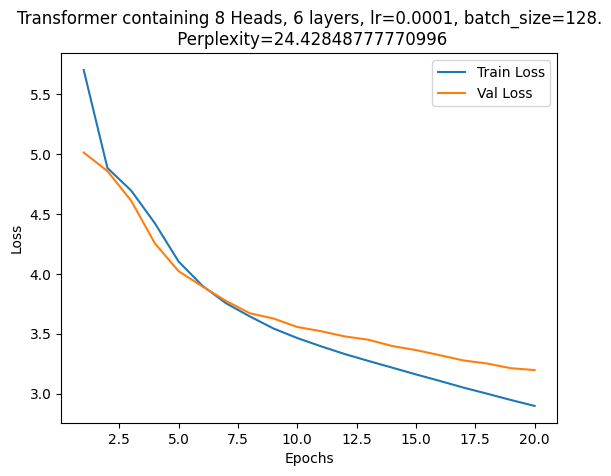

In [28]:
plt.plot(torch.arange(1, 21), train_losses_1, label='Train Loss')
plt.plot(torch.arange(1, 21), val_losses_1, label= 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Transformer containing 8 Heads, 6 layers, lr=0.0001, batch_size=128.\n Perplexity={perplexity_1}')
plt.legend(loc="upper right")
plt.show();

#### Translating a Sample Sentence - Greedy Decoding

In [50]:
def translate_sentence(model, sentence, vocab_src, vocab_tgt, max_length=50):
    """
    Translates a given source sentence into the target language using a trained Transformer model.
    The function preprocesses the input sentence by tokenizing and converting it to tensor format, then uses the model's
    encode and decode methods to generate the translated sentence. The translation process is performed token by token
    using greedy decoding, selecting the most likely next token at each step until an <eos> token is produced or the
    maximum length is reached.

    Parameters:
    - model (torch.nn.Module): The trained Transformer model.
    - sentence (str): The source sentence to translate.
    - vocab_src (dict): The source vocabulary mapping of tokens to indices. It should include special tokens such as
      '<bos>' (beginning of sentence) and '<eos>' (end of sentence).
    - vocab_tgt (dict): The target vocabulary mapping of indices to tokens. It should provide a method `lookup_token`
      to convert token indices back to the string representation.
    - max_length (int, optional): The maximum allowed length for the generated translation. The decoding process will
      stop when this length is reached if an <eos> token has not yet been generated.

    Returns:
    - str: The translated sentence as a string of text in the target language.
    """
    ### WRITE YOUR CODE HERE
    model.eval()
    src_tokens = ['<bos>'] + [token for token in tokenizer_de(sentence)] +  ['<eos>']
    src_tensor = torch.tensor([vocab_src[token] for token in src_tokens]).int().unsqueeze(0).to(device)

    trg_indexes = [vocab_tgt.get_stoi()['<bos>']]

    for i in range(max_length):
        trg_tensor = torch.tensor(trg_indexes).int().unsqueeze(0).to(device)

        with torch.no_grad():

          # generate the logits
            logits = model(src_tensor, trg_tensor)

            # select the newly predicted token
            pred_token = logits.argmax(2)[:,-1].item()

            # if <eos> token or max length, stop generating
            if pred_token == vocab_tgt.get_stoi()['<eos>'] or i == (max_length-1):

                # decoder input
                trg_input = vocab_tgt.lookup_tokens(trg_indexes)

                # decoder output
                trg_output = vocab_tgt.lookup_tokens(logits.argmax(2).squeeze(0).tolist())

                return ' '.join(trg_output[:-1])

              # else, continue generating
            else:
            # add the token
                trg_indexes.append(pred_token)

In [51]:
src_sentence = "Ein kleiner Junge spielt draußen mit einem Ball."  # German for "A little boy playing outside with a ball."
translated_sentence = translate_sentence(model, src_sentence, vocab_src, vocab_tgt)
print(f'Translated sentence: {translated_sentence}')

Translated sentence: A little boy is playing with a toy in a pool .


In [42]:
src_sentence = "Ein kleiner Junge spielt draußen mit einem Ball."  # German for "A little boy playing outside with a ball."
translated_sentence = translate_sentence(model, src_sentence, vocab_src, vocab_tgt)
print(f'Translated sentence: {translated_sentence}')

Translated sentence: A little boy is playing with a toy in a pool


You should get a translation similar to the reference after 20 epochs of training.

In [36]:
eg_sentences = [('Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen',
  'A group of men are loading cotton onto a truck'),
 ('Ein Mann schläft in einem grünen Raum auf einem Sofa.',
  'A man sleeping in a green room on a couch.'),
 ('Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.',
  "A boy wearing headphones sits on a woman's shoulders.")]

In [37]:
def translate_egs(model, vocab_src, vocab_tgt):
  for sentence, target_sentence in eg_sentences:
    translated_sentence = translate_sentence(model, sentence, vocab_src, vocab_tgt)
    print("Source: ", sentence)
    print("Target: ", target_sentence)
    print("Translation: ", translated_sentence)
    print()

In [52]:
translate_egs(model, vocab_src, vocab_tgt)

Source:  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:  A group of men are loading cotton onto a truck
Translation:  A group of people are standing in a city area .

Source:  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:  A man sleeping in a green room on a couch.
Translation:  A man and a woman are sitting on a bench .

Source:  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:  A boy wearing headphones sits on a woman's shoulders.
Translation:  A young boy wearing a red jacket is standing on a bench .



In [39]:
import os
save_path = os.getcwd() + '/model_' + '1'
save_path

'/kaggle/working/model_1'

In [40]:
torch.save(model, save_path)

# Experimenting with different Model Parameters

In [53]:
def experiment_model(n_heads=8, N=6, lr=0.0001, batch_size=128, n_epochs = 20):
  d_ff = 2048    # Dimension of feed forward networks
  max_seq_length = 5000 # Maximum sequence length
  dropout = 0.1  # Dropout rate

  # Assume pad_idx is the padding index in the target vocabulary
  pad_idx = vocab_tgt['<pad>']


  model = Transformer(src_vocab_size, tgt_vocab_size, d_model, N=N, n_heads=n_heads,
                      d_ff=d_ff, max_seq_length=max_seq_length, dropout=dropout, pad_idx=pad_idx)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)

  grad_clip = 1
  optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

  criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

  train_itr = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
  valid_itr = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

  train_loss_list = []
  val_loss_list = []

  for epoch in range(n_epochs):
      train_loss = train(model, train_itr, optimizer, criterion, grad_clip)
      val_loss = evaluate(model, valid_itr, criterion)

      print(f'\nEpoch: {epoch + 1}')
      print(f'\tTrain Loss: {train_loss:.3f}')
      print(f'\tVal Loss: {val_loss:.3f}')

      train_loss_list.append(train_loss)
      val_loss_list.append(val_loss)

  ppl = float(torch.exp(torch.tensor(val_loss_list[-1])).numpy())
  return model, train_loss_list, val_loss_list, ppl

## Model 2:
*   Heads = 16
*   Layers = 6
*   lr = 0.0001
*   batch_size = 128

In [54]:
model_2, train_losses_2, val_losses_2, ppl_2 = experiment_model(n_heads=16)


Epoch: 1
	Train Loss: 5.717
	Val Loss: 5.034

Epoch: 2
	Train Loss: 4.888
	Val Loss: 4.794

Epoch: 3
	Train Loss: 4.702
	Val Loss: 4.667

Epoch: 4
	Train Loss: 4.506
	Val Loss: 4.342

Epoch: 5
	Train Loss: 4.174
	Val Loss: 4.079

Epoch: 6
	Train Loss: 3.957
	Val Loss: 3.930

Epoch: 7
	Train Loss: 3.813
	Val Loss: 3.823

Epoch: 8
	Train Loss: 3.692
	Val Loss: 3.743

Epoch: 9
	Train Loss: 3.583
	Val Loss: 3.656

Epoch: 10
	Train Loss: 3.496
	Val Loss: 3.604

Epoch: 11
	Train Loss: 3.424
	Val Loss: 3.551

Epoch: 12
	Train Loss: 3.357
	Val Loss: 3.503

Epoch: 13
	Train Loss: 3.294
	Val Loss: 3.465

Epoch: 14
	Train Loss: 3.225
	Val Loss: 3.417

Epoch: 15
	Train Loss: 3.163
	Val Loss: 3.371

Epoch: 16
	Train Loss: 3.104
	Val Loss: 3.323

Epoch: 17
	Train Loss: 3.047
	Val Loss: 3.300

Epoch: 18
	Train Loss: 2.994
	Val Loss: 3.266

Epoch: 19
	Train Loss: 2.943
	Val Loss: 3.228

Epoch: 20
	Train Loss: 2.895
	Val Loss: 3.193


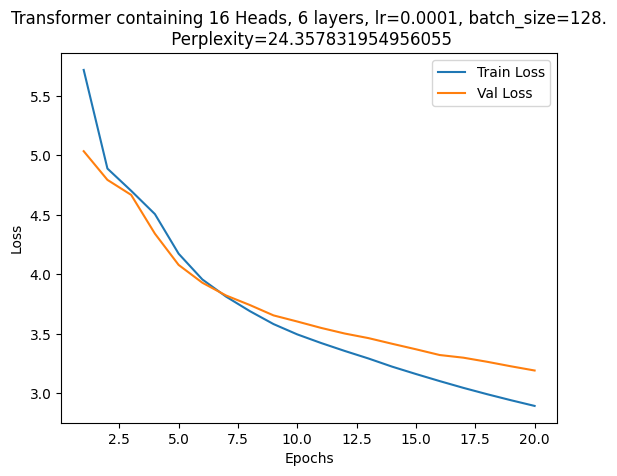

In [55]:
plt.plot(torch.arange(1, 21), train_losses_2, label='Train Loss')
plt.plot(torch.arange(1, 21), val_losses_2, label= 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Transformer containing 16 Heads, 6 layers, lr=0.0001, batch_size=128.\n Perplexity={ppl_2}')
plt.legend(loc="upper right")
plt.show();

In [56]:
src_sentence = "Ein kleiner Junge spielt draußen mit einem Ball."  # German for "A little boy playing outside with a ball."
translated_sentence_2 = translate_sentence(model_2, src_sentence, vocab_src, vocab_tgt)
print(f'Model 2 Translated sentence: {translated_sentence_2}')

Model 2 Translated sentence: A young boy is playing with a toy ball .


In [57]:
translate_egs(model_2, vocab_src, vocab_tgt)

Source:  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:  A group of men are loading cotton onto a truck
Translation:  A group of people are walking down a street .

Source:  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:  A man sleeping in a green room on a couch.
Translation:  A man and a woman are sitting on a bench .

Source:  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:  A boy wearing headphones sits on a woman's shoulders.
Translation:  A young boy is sitting on a bench with a red bag .



## Model 3:
*   Heads = 8
*   Layers = 8
*   lr = 0.0001
*   batch_size = 128

In [58]:
model_3, train_losses_3, val_losses_3, ppl_3 = experiment_model(N=8)


Epoch: 1
	Train Loss: 5.878
	Val Loss: 5.206

Epoch: 2
	Train Loss: 5.180
	Val Loss: 5.153

Epoch: 3
	Train Loss: 5.118
	Val Loss: 5.171

Epoch: 4
	Train Loss: 5.065
	Val Loss: 5.252

Epoch: 5
	Train Loss: 4.976
	Val Loss: 5.522

Epoch: 6
	Train Loss: 4.933
	Val Loss: 5.714

Epoch: 7
	Train Loss: 4.915
	Val Loss: 5.706

Epoch: 8
	Train Loss: 4.895
	Val Loss: 5.588

Epoch: 9
	Train Loss: 4.868
	Val Loss: 5.984

Epoch: 10
	Train Loss: 4.805
	Val Loss: 5.358

Epoch: 11
	Train Loss: 4.741
	Val Loss: 5.622

Epoch: 12
	Train Loss: 4.684
	Val Loss: 5.667

Epoch: 13
	Train Loss: 4.661
	Val Loss: 5.737

Epoch: 14
	Train Loss: 4.635
	Val Loss: 5.741

Epoch: 15
	Train Loss: 4.626
	Val Loss: 5.617

Epoch: 16
	Train Loss: 4.599
	Val Loss: 5.816

Epoch: 17
	Train Loss: 4.581
	Val Loss: 5.735

Epoch: 18
	Train Loss: 4.565
	Val Loss: 5.874

Epoch: 19
	Train Loss: 4.547
	Val Loss: 5.719

Epoch: 20
	Train Loss: 4.552
	Val Loss: 6.498


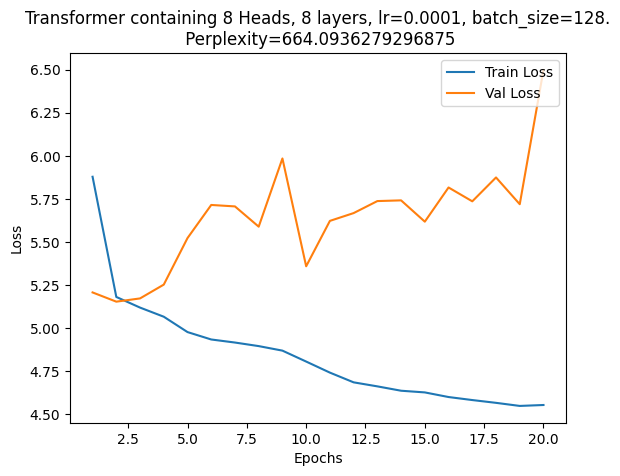

In [59]:
plt.plot(torch.arange(1, 21), train_losses_3, label='Train Loss')
plt.plot(torch.arange(1, 21), val_losses_3, label= 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Transformer containing 8 Heads, 8 layers, lr=0.0001, batch_size=128.\n Perplexity={ppl_3}')
plt.legend(loc="upper right")
plt.show();

In [60]:
src_sentence = "Ein kleiner Junge spielt draußen mit einem Ball."  # German for "A little boy playing outside with a ball."
translated_sentence_3 = translate_sentence(model_3, src_sentence, vocab_src, vocab_tgt)
print(f'Model 3 Translated sentence: {translated_sentence_3}')

Model 3 Translated sentence: A A A A a a a a . .


In [61]:
translate_egs(model_3, vocab_src, vocab_tgt)

Source:  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:  A group of men are loading cotton onto a truck
Translation:  A A A A are are a a .

Source:  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:  A man sleeping in a green room on a couch.
Translation:  A A A A a a a a a a . .

Source:  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:  A boy wearing headphones sits on a woman's shoulders.
Translation:  A A A A woman is is a a a a . .



## Model 4:
*   Heads = 8
*   Layers = 6
*   lr = 0.001
*   batch_size = 64

In [62]:
model_4, train_losses_4, val_losses_4, ppl_4 = experiment_model(lr=0.001, batch_size = 64)


Epoch: 1
	Train Loss: 5.744
	Val Loss: 6.694

Epoch: 2
	Train Loss: 5.326
	Val Loss: 11.725

Epoch: 3
	Train Loss: 5.236
	Val Loss: 12.805

Epoch: 4
	Train Loss: 5.201
	Val Loss: 12.030

Epoch: 5
	Train Loss: 5.185
	Val Loss: 11.413

Epoch: 6
	Train Loss: 5.174
	Val Loss: 12.148

Epoch: 7
	Train Loss: 5.157
	Val Loss: 12.411

Epoch: 8
	Train Loss: 5.146
	Val Loss: 13.407

Epoch: 9
	Train Loss: 5.143
	Val Loss: 11.935

Epoch: 10
	Train Loss: 5.136
	Val Loss: 11.932

Epoch: 11
	Train Loss: 5.127
	Val Loss: 12.310

Epoch: 12
	Train Loss: 5.126
	Val Loss: 12.436

Epoch: 13
	Train Loss: 5.124
	Val Loss: 13.233

Epoch: 14
	Train Loss: 5.114
	Val Loss: 13.403

Epoch: 15
	Train Loss: 5.111
	Val Loss: 13.672

Epoch: 16
	Train Loss: 5.106
	Val Loss: 13.712

Epoch: 17
	Train Loss: 5.110
	Val Loss: 13.430

Epoch: 18
	Train Loss: 5.104
	Val Loss: 13.872

Epoch: 19
	Train Loss: 5.100
	Val Loss: 13.907

Epoch: 20
	Train Loss: 5.098
	Val Loss: 12.962


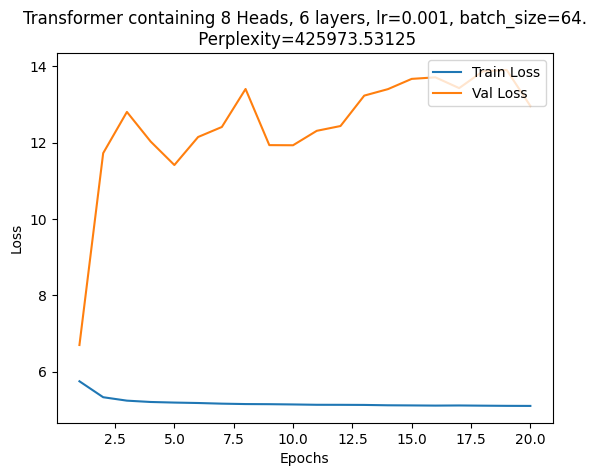

In [63]:
plt.plot(torch.arange(1, 21), train_losses_4, label='Train Loss')
plt.plot(torch.arange(1, 21), val_losses_4, label= 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Transformer containing 8 Heads, 6 layers, lr=0.001, batch_size=64.\n Perplexity={ppl_4}')
plt.legend(loc="upper right")
plt.show();

In [64]:
src_sentence = "Ein kleiner Junge spielt draußen mit einem Ball."  # German for "A little boy playing outside with a ball."
translated_sentence_4 = translate_sentence(model_4, src_sentence, vocab_src, vocab_tgt)
print(f'Model 4 Translated sentence: {translated_sentence_4}')

Model 4 Translated sentence: A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A


In [65]:
translate_egs(model_4, vocab_src, vocab_tgt)

Source:  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:  A group of men are loading cotton onto a truck
Translation:  A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A

Source:  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:  A man sleeping in a green room on a couch.
Translation:  A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A

Source:  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:  A boy wearing headphones sits on a woman's shoulders.
Translation:  A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A



## Results
 - Comparing the four models, it is evident that increasing the number of layers or the learning rate causes the models to overfit, resulting in poor translation quality.
 - Comparing Model 1 and Model 2, increasing the number of heads in Model 2 results in a slight decrease in perplexity. However, this increase in complexity does not seem to provide significant benefits.